In [16]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import plotly.express as px
sb.set()

In [2]:
demo_df = pd.read_csv("dataset/esea_meta_demos.part1.csv")

In [3]:
dmg_df = pd.read_csv("dataset/esea_master_dmg_demos.part1.csv")

In [4]:
kill_df = pd.read_csv("dataset/esea_master_kills_demos.part1.csv")

In [5]:
map_df = pd.read_csv("dataset/map_data.csv").rename(columns={'Unnamed: 0':'map_name'})
map_dict = map_df.set_index("map_name").transpose().to_dict()

In [6]:
# insert duration per round
demo_with_duration_df = demo_df.assign(round_duration=lambda x: x.end_seconds - x.start_seconds)
demo_with_duration_df.head()

,file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration
0,esea_match_13770997.dem,de_overpass,1,94.30782,160.9591,Hentai Hooligans,Terrorist,PISTOL_ROUND,4300,4250,66.65128
1,esea_match_13770997.dem,de_overpass,2,160.95910,279.3998,Hentai Hooligans,Terrorist,ECO,6300,19400,118.44070
2,esea_match_13770997.dem,de_overpass,3,279.39980,341.0084,Hentai Hooligans,Terrorist,SEMI_ECO,7650,19250,61.60860
3,esea_match_13770997.dem,de_overpass,4,341.00840,435.4259,Hentai Hooligans,Terrorist,NORMAL,24900,23400,94.41750
4,esea_match_13770997.dem,de_overpass,5,435.42590,484.2398,Animal Style,CounterTerrorist,ECO,5400,20550,48.81390


In [7]:
file_unique = demo_with_duration_df['file'].unique() 

incomplete_matches = []

# put every match in a list that does not have a complete set of rounds by comparing difference in index and round of min and max
for map_name in file_unique:
    max_id = demo_with_duration_df.file.values.searchsorted(map_name, side='right')
    min_id = demo_with_duration_df.file.values.searchsorted(map_name, side='left')
    expected_total_rounds = max_id-min_id
    actual_rounds = demo_with_duration_df.iloc[max_id-1]['round']

    if (actual_rounds!=expected_total_rounds):
        incomplete_matches.append(map_name)

demo_clean_df = demo_with_duration_df[~demo_with_duration_df['file'].isin(incomplete_matches)]

In [8]:
dmg_df.head()

,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,...,wp,wp_type,att_id,att_rank,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y
0,esea_match_13770997.dem,1,14372,111.8476,World,Animal Style,None,CounterTerrorist,1,0,...,Unknown,Unkown,0,0,76561198055054795,0,0.0000,0.00000,0.0000,0.000000
1,esea_match_13770997.dem,1,15972,124.3761,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,18,9,...,USP,Pistol,76561198048742997,0,76561198082200410,0,-1499.6900,63.33829,-669.5558,-79.769570
2,esea_match_13770997.dem,1,16058,125.0495,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,100,0,...,USP,Pistol,76561198055054795,0,76561197961009213,0,-1066.8740,3.44563,-614.1868,-91.707770
3,esea_match_13770997.dem,1,16066,125.1121,Hentai Hooligans,Animal Style,Terrorist,CounterTerrorist,12,7,...,Glock,Pistol,76561198082200410,0,76561198055054795,0,-747.3146,-49.32681,-1065.5560,9.381622
4,esea_match_13770997.dem,1,16108,125.4410,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,15,7,...,USP,Pistol,76561198048742997,0,76561198082200410,0,-1501.8610,49.19798,-748.4188,-53.469220


In [9]:
kill_df.head()

,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,wp,wp_type,ct_alive,t_alive,is_bomb_planted
0,esea_match_13770997.dem,1,16058,30.74165,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,USP,Pistol,5,4,False
1,esea_match_13770997.dem,1,16210,31.93185,Hentai Hooligans,Animal Style,Terrorist,CounterTerrorist,Glock,Pistol,4,4,False
2,esea_match_13770997.dem,1,16510,34.28094,Hentai Hooligans,Animal Style,Terrorist,CounterTerrorist,Glock,Pistol,3,4,False
3,esea_match_13770997.dem,1,17104,38.93212,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,USP,Pistol,3,3,False
4,esea_match_13770997.dem,1,17338,40.76441,Hentai Hooligans,Animal Style,Terrorist,CounterTerrorist,Glock,Pistol,2,3,False


In [10]:
# combine df and remove duplicate col
kill_confirm_df = dmg_df.merge(kill_df, how='inner', on=['file','tick'], suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)').drop(columns=['att_rank','vic_rank'])
kill_confirm_df.head()

,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,...,wp,wp_type,att_id,vic_id,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,ct_alive,t_alive
0,esea_match_13770997.dem,1,16058,125.0495,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,100,0,...,USP,Pistol,76561198055054795,76561197961009213,-1066.8740,3.44563,-614.1868,-91.70777,5,4
1,esea_match_13770997.dem,1,16210,126.2397,Hentai Hooligans,Animal Style,Terrorist,CounterTerrorist,6,0,...,Glock,Pistol,76561198082200410,76561198048742997,-751.6216,-55.69779,-1499.8930,61.62376,4,4
2,esea_match_13770997.dem,1,16510,128.5888,Hentai Hooligans,Animal Style,Terrorist,CounterTerrorist,87,0,...,Glock,Pistol,76561198037331400,76561198055054795,-1025.8290,-487.79010,-1051.8220,98.66519,3,4
3,esea_match_13770997.dem,1,17104,133.2399,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,41,0,...,USP,Pistol,76561198055191021,76561198082200410,-1882.5430,506.90220,-782.7830,176.01590,3,3
4,esea_match_13770997.dem,1,17338,135.0722,Hentai Hooligans,Animal Style,Terrorist,CounterTerrorist,8,0,...,Glock,Pistol,76561198798659644,76561198169360549,-1104.0010,-127.94100,-1888.1070,-367.58030,2,3


In [11]:
# combine df and remove duplicate col
cleaned_df = kill_confirm_df.merge(demo_clean_df, how='inner', on=['file','round'], suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
cleaned_df.head()

,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,...,t_alive,map,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration
0,esea_match_13779704.dem,1,21093,164.4769,Team 1,Team 2,CounterTerrorist,Terrorist,85,0,...,4,de_cache,131.2592,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,56.8597
1,esea_match_13779704.dem,1,21251,165.7130,Team 1,Team 2,CounterTerrorist,Terrorist,37,0,...,3,de_cache,131.2592,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,56.8597
2,esea_match_13779704.dem,1,21341,166.4171,Team 2,Team 1,Terrorist,CounterTerrorist,100,0,...,3,de_cache,131.2592,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,56.8597
3,esea_match_13779704.dem,1,21883,170.6573,Team 1,Team 2,CounterTerrorist,Terrorist,100,0,...,2,de_cache,131.2592,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,56.8597
4,esea_match_13779704.dem,1,23091,180.1078,Team 1,Team 2,CounterTerrorist,Terrorist,67,0,...,1,de_cache,131.2592,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,56.8597


In [27]:
demo_clean_df.sort_values(by=['round','file']) # test

,file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration
24,esea_match_13779704.dem,de_cache,1,131.2592,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,56.8597
63,esea_match_13779769.dem,de_inferno,1,131.5340,221.2626,Team 1,CounterTerrorist,PISTOL_ROUND,4400,4250,89.7286
112,esea_match_13779771.dem,de_inferno,1,131.7829,250.9257,Team 2,Terrorist,PISTOL_ROUND,3550,4350,119.1428
139,esea_match_13779775.dem,de_inferno,1,131.8334,235.4224,Team 1,CounterTerrorist,PISTOL_ROUND,4250,4350,103.5890
169,esea_match_13779776.dem,de_overpass,1,131.3957,209.9951,Team 1,CounterTerrorist,PISTOL_ROUND,4100,3300,78.5994
...,...,...,...,...,...,...,...,...,...,...,...
179656,esea_match_13790831.dem,de_cache,53,5260.9780,5384.8860,Team 1,Terrorist,NORMAL,32050,29900,123.9080
106382,esea_match_13786284.dem,de_cache,54,5111.0860,5230.8210,Team 1,Terrorist,NORMAL,26650,28050,119.7350
132086,esea_match_13787779.dem,de_cache,54,5209.3420,5301.2890,Team 1,Terrorist,NORMAL,35450,25150,91.9470
137426,esea_match_13788110.dem,de_inferno,54,5653.4230,5789.8660,Team 1,Terrorist,NORMAL,29100,28300,136.4430


In [20]:
#seperate df based on maps
df_sep_map = {}

for map_name in map_dict.keys():
    df = cleaned_df[cleaned_df['map']==map_name] 
    df_clean = df[['map','vic_pos_x','vic_pos_y','att_pos_x','att_pos_y']] # select values for mapping
    df_sep_map[map_name] = df_clean

Map: de_cache


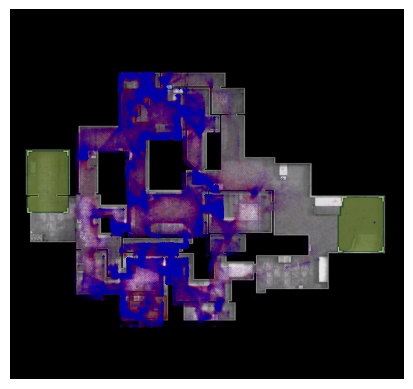

_____________________________________________________________________
Map: de_cbble


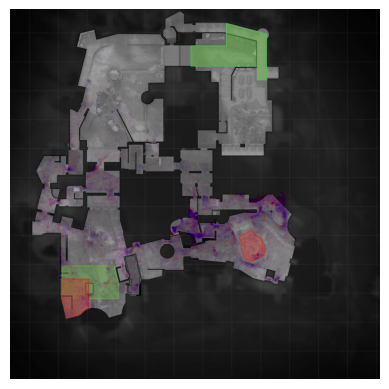

_____________________________________________________________________
Map: de_dust2


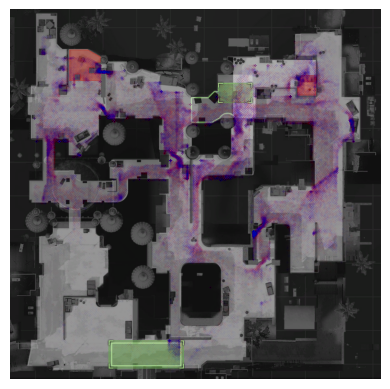

_____________________________________________________________________
Map: de_inferno


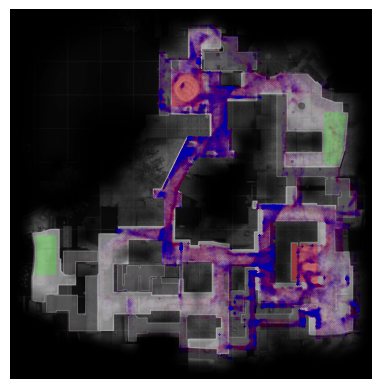

_____________________________________________________________________
Map: de_mirage


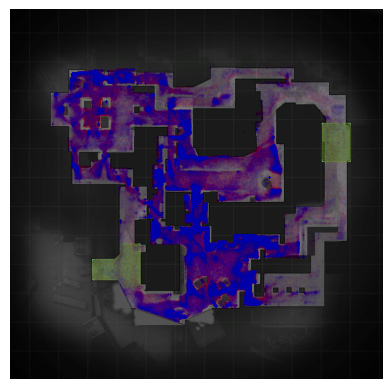

_____________________________________________________________________
Map: de_overpass


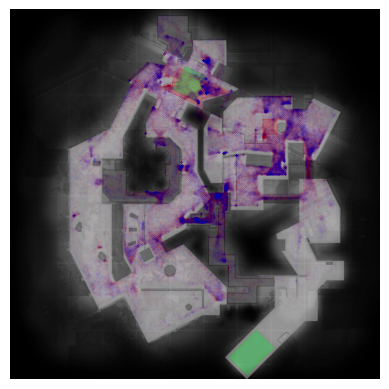

_____________________________________________________________________
Map: de_train


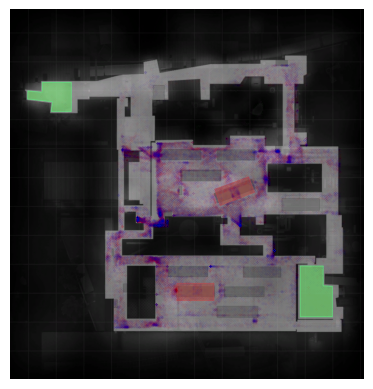

_____________________________________________________________________


In [21]:
for map_name in df_sep_map.keys():
    print("Map:",map_name)
    endx = map_dict[map_name]['EndX']
    endy = map_dict[map_name]['EndY']
    resx = map_dict[map_name]['ResX']
    resy = map_dict[map_name]['ResY']
    startx = map_dict[map_name]['StartX']
    starty = map_dict[map_name]['StartY']
    df = df_sep_map[map_name]
    
    im = plt.imread('maps/'+map_name+'.png')
    plt.axis([startx, endx, starty, endy])
    plt.scatter(x=df.vic_pos_x, y=df.vic_pos_y, s=0.0001, zorder=1, c='red')
    plt.scatter(x=df.att_pos_x, y=df.att_pos_y, s=0.0001, zorder=1, c='blue')
    plt.imshow(im, zorder=0, extent=[startx, endx, starty, endy])
    plt.axis('off')
    plt.show()
    print("_____________________________________________________________________")